# __Group Project 3 - Team Terence Gorman__
<br>


### <span style = "color:dar">__Team Members: Marc Bonnot (*Team Manager*), Ce (Faye) Fang, Dojun Kim, Kimberley Fan, Jane Wang, Qianhao (Harry) Zhong__
<br>


## **1. Project Topic & Goal:**


Our group aims to explore the relationship between food expenditure and households in Panama and their nutritional adequacy of diet.

- Estimate the impact of different household characteristics on food expenditure.
- Evaluate the household wealth’s correlation with food expenditures.
- Analyze the regional impact on food expenditure.
- Calculate the proportion of households that can fulfill the dietary recommendations.
> 
<br>


## **2. [A] Choice of a population, with supporting expenditure data:**

Our group is interested in households in Panama, specifically in different provinces. We choose the capital panama city as the reference group, comparing the food expenditures of households in other provinces with the capital.


## **3. Data Description:**

> ####  __Main DataSet - [Panama Dataset](https://docs.google.com/spreadsheets/d/1P7OQG9cmBSS4dY6ZPI1HOPHW9shCTSkguDVnUCuh3Is/edit#gid=1352592273):__ This spreadsheet encompasses all the data we aim to manipulate. Initially, it contained subsheets titled <span style = "color:red"> <u>Household Characteristics, FCT (Food Composition Table), Food Expenditures, and Food Prices</span>, all written in Panamanian terminology. To facilitate understanding, we've added translated versions of some of these sheets, namely <span style = "color:blue"><u>Food Expenditures Translated, FCT Translated, and Food Prices Translated</span>.
> * #### __Subsheet 1 - [Household Characteristics](https://docs.google.com/spreadsheets/d/1P7OQG9cmBSS4dY6ZPI1HOPHW9shCTSkguDVnUCuh3Is/edit#gid=640496182):__ This subsheet presents household data collected from various provinces in Panama, such as Herrera, Bocas Del Toro, Chiriquí, Colón, and Panamá, starting from 1997 to 2008. The sheet provides a breakdown of household composition by gender and age group across different provinces, reflecting the demographic diversity within the surveyed regions.
> * #### __Subsheet 2 - [FCT](https://docs.google.com/spreadsheets/d/1P7OQG9cmBSS4dY6ZPI1HOPHW9shCTSkguDVnUCuh3Is/edit#gid=2137085684) and [FCT Translated](https://docs.google.com/spreadsheets/d/1P7OQG9cmBSS4dY6ZPI1HOPHW9shCTSkguDVnUCuh3Is/edit#gid=959017411):__ This sheet details the nutritional content of various foods per 100 grams of edible portion. Each row represents a different food item, and the columns contain information about its water content, energy, macronutrients, etc.
> * #### __Subsheet 3 - [Food Expenditures](https://docs.google.com/spreadsheets/d/1P7OQG9cmBSS4dY6ZPI1HOPHW9shCTSkguDVnUCuh3Is/edit#gid=1361705941) and [Food Expenditures Translated](https://docs.google.com/spreadsheets/d/1P7OQG9cmBSS4dY6ZPI1HOPHW9shCTSkguDVnUCuh3Is/edit#gid=1352592273):__ This sheet is a multi-indexed dataset containing information on food expenditure across various households. The indexing involves three levels: year, region, and household identifier. This structure allows for an organized and accessible way to analyze how food expenditure varies not only over time but also across different geographical locations and among distinct households.
> * #### __Subsheet 4 - [Food Prices](https://docs.google.com/spreadsheets/d/1P7OQG9cmBSS4dY6ZPI1HOPHW9shCTSkguDVnUCuh3Is/edit#gid=1550902571) and [Food Prices Translated](https://docs.google.com/spreadsheets/d/1P7OQG9cmBSS4dY6ZPI1HOPHW9shCTSkguDVnUCuh3Is/edit#gid=1767733042):__ This spreadsheet appears to contain a compilation of food items along with their respective prices and measurements across different regions and time periods (1997 and 2003) in Panama. Each row appears to represent a distinct food item and its associated measurement, while each column signifies various regions or time periods. The values within each cell indicate the corresponding price and unit of measurement for the specified region or period.

<br>

## **4. Project Deliverables:**

### *Packages Import*:

In [ ]:
# The lengthy output has been hidden
!pip install -r requirements.txt -q
!pip install CFEDemands --upgrade --pre -q
!pip install eep153_tools --upgrade -q

In [ ]:
from cfe.estimation import drop_columns_wo_covariance
from eep153_tools.sheets import read_sheets
import matplotlib.pyplot as plt
from cfe import Regression
import numpy as np
import pandas as pd
import cfe

<br>

### *DATA Import, DATA Cleaning*:

In [ ]:
InputFiles = {"Expenditures": ("1P7OQG9cmBSS4dY6ZPI1HOPHW9shCTSkguDVnUCuh3Is", "Food Expenditures Translated"),
              'Prices':('1P7OQG9cmBSS4dY6ZPI1HOPHW9shCTSkguDVnUCuh3Is','Food Prices Translated'),
              'HH Characteristics':('1P7OQG9cmBSS4dY6ZPI1HOPHW9shCTSkguDVnUCuh3Is','Household Characteristics'),
              'FCT':('1P7OQG9cmBSS4dY6ZPI1HOPHW9shCTSkguDVnUCuh3Is','FCT Translated'),
              'RDI':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','RDI')}

In [ ]:
def get_clean_sheet(key,sheet=None):

    df = read_sheets(key,sheet=sheet)
    
    df.columns = [c.strip() for c in df.columns.tolist()]

    df = df.loc[:,~df.columns.duplicated(keep='first')]   

    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

    df = df.loc[~df.index.duplicated(), :]

    return df

In [ ]:
################# Get expenditures #################
Expenditures = get_clean_sheet(InputFiles['Expenditures'][0],
                    sheet=InputFiles['Expenditures'][1])

if 'm' not in Expenditures.columns:  # If Expenditures doesn't include column "m", create one manually.
    Expenditures['m'] = 1
    
Expenditures = Expenditures.set_index(['i','t','m'])
Expenditures.columns.name = 'j'

Expenditures = Expenditures.apply(lambda x: pd.to_numeric(x,errors='coerce'))
Expenditures = Expenditures.replace(0,np.nan)  # Convert all zeros to NaN


################# Get HH characteristics #################
HH_characteristics = get_clean_sheet(InputFiles['HH Characteristics'][0],
                    sheet=InputFiles['HH Characteristics'][1])

if 'm' not in HH_characteristics.columns:
    HH_characteristics['m'] = 1

HH_characteristics = HH_characteristics.set_index(['i','t','m'])
HH_characteristics.columns.name = 'k'  # Assign a overarching column name to coloumn indexes

HH_characteristics = HH_characteristics.apply(lambda x: pd.to_numeric(x,errors='coerce'))



################# Get prices #################
price_url = 'https://docs.google.com/spreadsheets/d/1P7OQG9cmBSS4dY6ZPI1HOPHW9shCTSkguDVnUCuh3Is/edit#gid=1352592273'

prices = read_sheets(price_url, sheet='Food Prices Translated', nheaders=2)
prices.columns.names = ['t', 'm']  # Assign two column names to two headers
# since there are multiple prices for food in various sizes, we choose to use average price 
prices.groupby(level='j').mean()
prices=prices.transpose()
if 'm' not in prices.columns:  # Supply "market" indicator if missing
    prices['m'] = 1  
prices = prices.apply(lambda x: pd.to_numeric(x,errors='coerce'))
prices = prices.replace(0,np.nan)



################# fct #################
fct = get_clean_sheet(InputFiles['FCT'][0],
                    sheet=InputFiles['FCT'][1])

fct = fct.set_index('j')
fct.columns.name = 'n'
fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))



################# RDI, if available (consider using US) #################
rdi = get_clean_sheet(InputFiles['RDI'][0],
                    sheet=InputFiles['RDI'][1])

rdi = rdi.set_index('n')
rdi.columns.name = 'k'

<br>

### *Cleaned DataFrame Display*:

In [ ]:
Expenditures.head()

,,j,Vegetable oil,Avocados,There Green,Garlic,Infant Food,Celery,Rice,Chickpeas,Sugar,Coffee and tea,...,"Sodas, Soft Drinks and Juices",Canned Soup,third other,Tomato,Beef Viscera,Chicken or Hen Viscera,Yucca,Carrot,Pumpkin / Chayote,Yam
i,t,m,,,,,,,,,,,,,,,,,,,,,
19971000,1997,Chíriqui,6.0,NaN,0.5,NaN,2.7,0.3,7.25,NaN,1.6,NaN,...,8.0,0.7,NaN,NaN,NaN,NaN,NaN,0.8,NaN,0.4
19971001,1997,Chíriqui,NaN,NaN,NaN,NaN,NaN,NaN,4.80,NaN,NaN,1.4,...,1.5,NaN,NaN,0.3,NaN,NaN,NaN,NaN,NaN,NaN
19971002,1997,Chíriqui,3.5,NaN,NaN,NaN,NaN,NaN,6.00,NaN,2.0,3.6,...,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
19971003,1997,Chíriqui,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19971005,1997,Chíriqui,3.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5,1.5,...,NaN,0.7,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [ ]:
HH_characteristics.head()

,,k,women,boys,men,girls,Males 00-03,Females 00-03,Males 04-08,Females 04-08,Males 09-13,Females 09-13,Males 14-18,Females 14-18,Males 19-30,Females 19-30,Males 31-50,Females 31-50,Males 51-99,Females 51-99,log HSize
i,t,m,,,,,,,,,,,,,,,,,,,
1997125,1997,Herrera,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1.098612
1997160,1997,Herrera,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1.098612
1997170,1997,Bocas Del Toro,1,3,1,4,1,2,1,0,0,1,1,1,0,0,0,1,1,0,2.197225
1997177,1997,Bocas Del Toro,4,9,1,5,2,1,4,1,1,3,2,0,0,2,0,2,1,0,2.944439
1997178,1997,Bocas Del Toro,2,1,2,2,0,0,0,1,1,0,0,1,2,0,0,1,0,1,1.945910


In [ ]:
prices.head()

j                   Vegetable oil                                            \
u                      1/2 gallon  None bottle    can gallon gram large bay   
t    m                                                                        
1997 Bocas Del Toro         3.225   NaN   1.20  2.975   6.70  NaN     1.500   
     Chíriqui               3.250  0.10   1.35    NaN   5.95  NaN     1.350   
     Coclé                  2.990  0.10   1.30    NaN   5.90  NaN     1.375   
     Colón                  3.250  0.10   1.34    NaN   5.75  NaN       NaN   
     Darién                 3.200  0.25   1.40    NaN   4.85  NaN     1.525   

j                                                ... Pumpkin / Chayote  \
u                   liter medium bar milliliter  ...              unit   
t    m                                           ...                     
1997 Bocas Del Toro   NaN      1.050        NaN  ...              0.10   
     Chíriqui         NaN      1.325        NaN  ...              0.10   
     Coclé            NaN      1.275        NaN  ...              0.15   
     Colón            NaN      0.850        NaN  ...              0.25   
     Darién           NaN      1.400        NaN  ...               NaN   

j                                     Yam                                 \
u                       value bag or sack gram ounce package pound  unit   
t    m                                                                     
1997 Bocas Del Toro       NaN         3.6  NaN   NaN     NaN  0.40   NaN   
     Chíriqui        0.084416         NaN  NaN   NaN     NaN  0.40  0.15   
     Coclé           0.201299         NaN  NaN   NaN     NaN  0.50  0.50   
     Colón           0.045455         NaN  NaN   NaN     NaN  0.40  0.60   
     Darién               NaN         NaN  NaN   NaN     NaN  0.15   NaN   

j                              m  
u                       value     
t    m                            
1997 Bocas Del Toro       NaN  1  
     Chíriqui        0.038961  1  
     Coclé                NaN  1  
     Colón           0.064935  1  
     Darién               NaN  1  

[5 rows x 691 columns]

In [ ]:
fct.head()

n,Water,Energy,Protein,Total Fat,Carbohydrates,Diet Fiber. total,Ash,Calcium,Match,Iron,...,Cholesterol,Potassium,Sodium,Zinc,Magnesium,Vit. B6,Vit. B12,Ac. Folic,Folate Equiv. F.D.,Edible Fraction
j,,,,,,,,,,,,,,,,,,,,,
Vegetable oil,0.00,884,0.00,100.00,0.00,0.0,0.00,0,0,0.00,...,0,0,0,0.00,0,0.00,0.0,0,0,1.00
Avocados,73.23,160,2.00,14.66,8.53,6.7,1.58,12,52,0.55,...,0,485,7,0.64,29,0.26,0.0,0,81,0.74
Sweet green chili,93.89,20,0.86,0.17,3.64,1.7,0.43,10,20,0.34,...,0,175,3,0.13,10,0.22,0.0,0,11,0.82
Garlic,63.80,134,5.30,0.20,29.30,0.0,1.40,38,134,1.40,...,0,529,19,1.00,0,0.00,0.0,3,0,0.94
Baby formula,3.00,510,12.50,27.00,54.30,0.0,3.20,530,420,9.00,...,0,600,180,6.00,55,0.30,1.5,80,136,1.00


In [ ]:
new_column_names = [
"Females 00-03", "Males 00-03", "Females 04-08", "Males 04-08", "Females 09-13", "Males 09-13", "Females 14-18", "Males 14-18",  "Females 19-30", "Males 19-30", "Females 31-50", "Males 31-50",  "Females 51-99", "Males 51-99"]
column_name_mapping = {old: new for old, new in zip(rdi.columns, new_column_names)}
rdi.rename(columns=column_name_mapping, inplace=True)

rdi.head()

k,F 00-03,M 00-03,F 04-08,M 04-08,F 09-13,M 09-13,F 14-18,M 14-18,F 19-30,M 19-30,F 31-50,M 31-50,F 51+,M 51+
n,,,,,,,,,,,,,,
Energy,1000.0,1000.0,1200.0,1400.0,1600.0,1800.0,1800.0,2200.0,2000.0,2400.0,1800.0,2200.0,1600.0,2000.0
Protein,13.0,13.0,19.0,19.0,34.0,34.0,46.0,52.0,46.0,56.0,46.0,56.0,46.0,56.0
Fiber,14.0,14.0,16.8,19.6,22.4,25.2,25.2,30.8,28.0,33.6,25.2,30.8,22.4,28.0
Folate,150.0,150.0,200.0,200.0,300.0,300.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0
Calcium,700.0,700.0,1000.0,1000.0,1300.0,1300.0,1300.0,1300.0,1000.0,1000.0,1000.0,1000.0,1200.0,1000.0


<br>

### *To analyze the impact of province or region on food expenditure, we opted to incorporate location-based indicator variables (also known as dummy variables) into the analysis of household characteristics.*

### *To avoid dummy variable trap, we omitted "Panamá" category thereby establishing it as the reference or baseline group, given its significance as Panama's capital*
<br>


In [ ]:
## Avoid re-running this code block. If you come across an Error, try to run the "Get HH characteristics" code block above again before you re-run this code block.

# add region indicator variables into HH_characteristics
dummies = pd.get_dummies(HH_characteristics.index.get_level_values(2), dtype=float)

##Columns "Bocas Del Taro" and "Bocas del Taro" represent the same region, we need to merge two columns first
dummies['Bocas del Toro'] = dummies['Bocas Del Toro'] + dummies['Bocas del Toro']
#Drop the repetitive one
dummies.drop('Bocas Del Toro', axis=1, inplace=True)
# Drop columns containing NaN
# To avoid multicollinearity in regression analysis, we must exclude one dummy variable, specifically "Panamá".
dummies = dummies.drop(columns=["#N/A", "Panamá"])

# add dummies variables to HH_chracteristics dataset
HH_characteristics_dummy = HH_characteristics.reset_index().join(dummies).set_index(["i", "t", "m"])
HH_characteristics_dummy

,,,women,boys,men,girls,Males 00-03,Females 00-03,Males 04-08,Females 04-08,Males 09-13,Females 09-13,...,Coclé,Colón,Comarca Emberá,Comarca Kuna Yala,Comarca Ngobe Bugle,Comarca de San Blas,Darién,Herrera,Los Santos,Veraguas
i,t,m,,,,,,,,,,,,,,,,,,,,,
1997125,1997,Herrera,1,1,1,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1997160,1997,Herrera,2,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1997170,1997,Bocas Del Toro,1,3,1,4,1,2,1,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1997177,1997,Bocas Del Toro,4,9,1,5,2,1,4,1,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1997178,1997,Bocas Del Toro,2,1,2,2,0,0,0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<br>

### *To examine the impact of an event on food expenditure, we will assess food expenditure/demand before and after the event by utilizing the following function to partition the dataset according to the event's time.*

In [ ]:
###function to split the dataset based on a time (before time t, after time t)
def split_data_t(time, data):
    before_t = data[data.index.get_level_values('t') <= time]
    after_t = data[data.index.get_level_values('t') > time]
    return before_t, after_t

<br>


## __[A] Estimate Demand System__

* ### *Main Demand System Regression Equation:*

<br>

$$
      y^j_{i} = A^j(p) + \gamma_j'd_i + \beta_j w_i + \zeta^j_i.
$$
<br>

> $y_{i}^j$ : *__Logarithmic expenditures on food $j$ by household $i$ at a particular time.__*
> 
> $A^j(p)$ : *__Sub-function of price $p$ of food $j$. It captures the demand elasticity of food $j$ .__*
>
> $\gamma_j'd_i$ : *__Variable $d_i$ represents household characteristics. The coefficient $\gamma_j'$ signifies how food expenditure changes in response to variations in household composition.__*
>
> $\beta_j w_i$ : *__Variable $w_i$ represents household wealth. The coefficient $\beta_j$ indicates how changes in household wealth affect food expenditure.__*
>
> $\zeta^j_i$ : *__The error term represents all sources of variation in the dependent variable ($y_{i}^j$) that are not explained by the independent variables included in regression function.__*


<br>

* ### *For simplicity, we decomposed this main equation into a sub-equation with only one unknown variable, we regressed the food expenditure on household composition (characteristics) first:*

<br>

$$
      y^j_{i} = \gamma_j'd_i + \zeta^j_i.
$$
<br>

In [ ]:
# To enhance the model's accuracy, we may encounter foods with very low consumption rates, making it challenging to reliably estimate their demand. 
# We can adjust the min_obs parameter; increasing its value will result in dropping more foods from the analysis.
# Expenditures = drop_columns_wo_covariance(Expenditures,min_obs=30)

# Take the logarithm to Expenditures. 
Expenditures_log = np.log(Expenditures)
use = Expenditures_log.index.intersection(HH_characteristics.index)
Expenditures_log = Expenditures_log.loc[use,:]
HH_characteristics = HH_characteristics.loc[use,:]

Expenditures_log = Expenditures_log.stack()
HH_characteristics = HH_characteristics.stack()

# Check that indices are in right places.
assert Expenditures_log.index.names == ['i','t','m','j']
assert HH_characteristics.index.names == ['i','t','m','k']

# Remove Ruplicated Indexes.
Expenditures_log = Expenditures_log.groupby(level = Expenditures_log.index.names).mean()

### Regession SetUp
result = Regression(y = Expenditures_log,d = HH_characteristics)

In [ ]:
# Save and reload result
result.to_pickle('estimate_result.pickle')
result = cfe.regression.read_pickle('estimate_result.pickle')

<br>

#### 📈📊 *__Regression Result Analytics [I] :__*

In [ ]:
## This code may take longer than 1 minute to process.
result.predicted_expenditures()

i         t     m                    j                            
20081     2008  Bocas Del Toro       Bread of salt and sweet bread     3.375907
                                     Cereals and Creams                2.191049
                                     Cheese (White and Yellow)         2.147660
                                     Chicken Eggs                      2.357673
                                     Chicken or Hen                   10.304188
                                                                        ...    
20087040  2008  Comarca Ngobe Bugle  Sodas, Soft Drinks and Juices     2.809195
                                     Sugar                             5.678374
                                     Tomato Pastes                     1.154606
                                     Vegetable oil                     2.747762
                                     Wheat flour                       3.611794
Length: 401475, dtype: float64

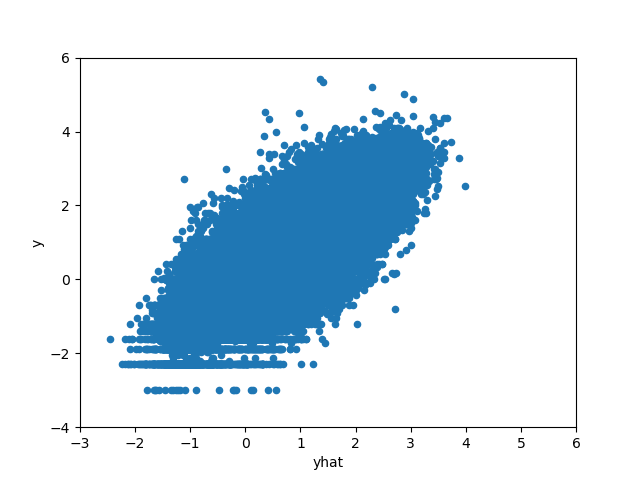

In [ ]:
# Compare predicted logarithmic expenditures with actual expenditures:
%matplotlib widget
df = pd.DataFrame({'y':Expenditures_log, 'yhat':result.get_predicted_log_expenditures()})
ax = df.plot.scatter(x='yhat',y='y')

# Set the x-axis limits from -3 to 6 and the y-axis limits from -4 to 6
ax.set_xlim(-3, 6) 
ax.set_ylim(-4, 6)
plt.show()

# # Plot a trendline
v = plt.axis()
vmin = np.max([v[0],v[2]])
vmax = np.max([v[1],v[3]])
plt.plot([vmin,vmax],[vmin,vmax], color = 'maroon')

### *__<span style = "color:skyblue">Interpretation: The preceding figure illustrates a scatter plot comparing the predicted food expenditures obtained from our regression model with the actual logarithmic food expenditures. It shows that the model's predictive ability and accuracy are moderate.__*

<br>

#### 📈📊 *__Regression Result Analytics [II] :__*

In [ ]:
# Demand Elasticity
result.get_beta().sort_values()

j
Rice                             0.187386
Salt                             0.195246
Lentils                          0.264018
Wheat flour                      0.290860
Sugar                            0.314590
Coffee and tea                   0.329990
Garlic                           0.396965
Vegetable oil                    0.436649
Chicken Eggs                     0.445068
Sardine and Tuna                 0.455480
Pasta                            0.467908
Onion                            0.484840
Pork Meats                       0.549794
Tomato Pastes                    0.557466
Evaporated Milk                  0.559358
Fish                             0.601187
Chicken or Hen                   0.604984
Cheese (White and Yellow)        0.677487
Scraped and Hard                 0.715488
Cereals and Creams               0.734314
Bread of salt and sweet bread    0.744691
Sausages                         0.764664
Cookies / Cakes and Sweets       0.775645
Sodas, Soft Drinks and Juices   

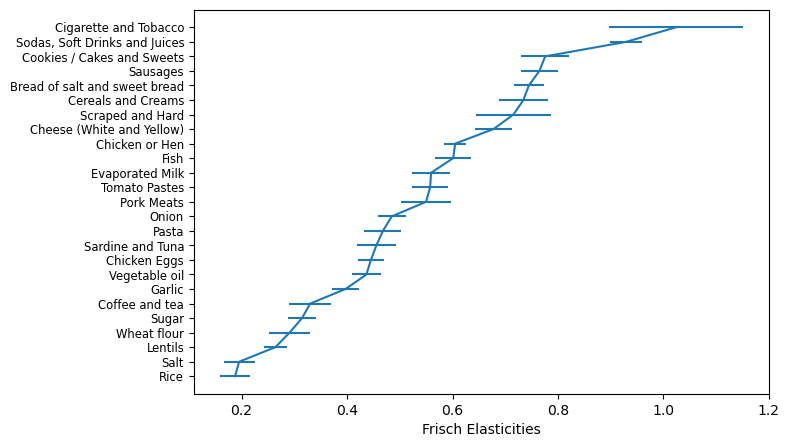

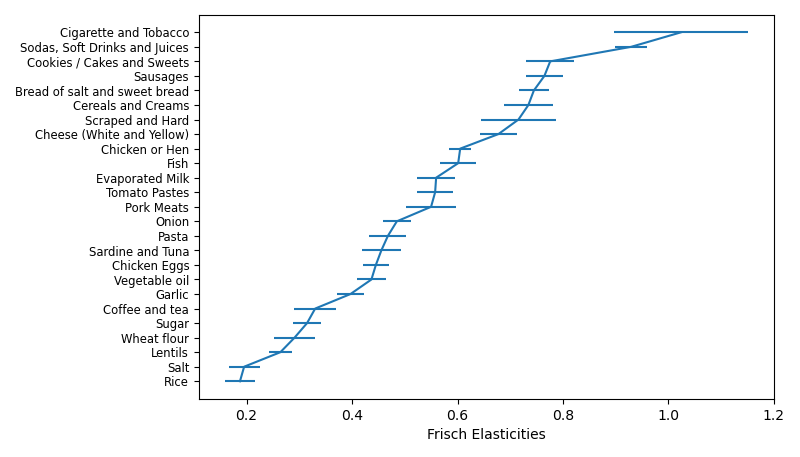

In [ ]:
# Graph of Demand Elasticity
result.graph_beta()

### *__<span style = "color:skyblue">Interpretation: The preceding analysis examines the elasticity of food demand concerning changes in income. From the graph above, it's evident that Panamanian individuals exhibit minimal elasticity in consuming staple foods such as rice, salt, and wheat flour. This suggests that their consumption (expenditure) of these items remains relatively stable despite fluctuations in income. Conversely, their demand for items such as tobacco, soda, bottled water, biscuits, and desserts displays greater elasticity. This implies that their consumption of these products is significantly influenced by changes in income, leading to notable increases or decreases accordingly.__*

<br>

#### 📈📊 *__Regression Result Analytics [III] :__*

In [ ]:
# Gamma is the coefficients of our regression of sub-equation
gamma_df = result.gamma
gamma_df.head()

k,women,boys,men,girls,Males 00-03,Females 00-03,Males 04-08,Females 04-08,Males 09-13,Females 09-13,Males 14-18,Females 14-18,Males 19-30,Females 19-30,Males 31-50,Females 31-50,Males 51-99,Females 51-99,log HSize,Constant
j,,,,,,,,,,,,,,,,,,,,
Bread of salt and sweet bread,0.928896,1.954474,1.879556,0.847209,-2.107362,-1.004839,-2.020383,-0.929842,-1.994762,-0.925665,-1.954114,-0.912913,-1.908584,-0.874673,-1.873908,-0.753566,-1.892542,-0.822073,0.582272,0.951692
Cereals and Creams,0.603309,-0.100440,-0.085149,0.577062,0.008921,-0.701238,0.032558,-0.651558,-0.027429,-0.736155,-0.061704,-0.736833,-0.026895,-0.592508,-0.026425,-0.469492,-0.084578,-0.679312,0.522169,0.604788
Cheese (White and Yellow),0.901415,0.593441,0.540033,0.861934,-0.740573,-1.008692,-0.662317,-0.954160,-0.634409,-0.967668,-0.644835,-0.937658,-0.586920,-0.860249,-0.558761,-0.772095,-0.555378,-0.866695,0.394491,0.781909
Chicken Eggs,0.310109,0.646511,0.620383,0.282517,-0.689612,-0.358357,-0.656058,-0.309634,-0.674289,-0.291746,-0.646770,-0.271319,-0.630492,-0.284392,-0.594709,-0.258133,-0.571783,-0.287817,0.283396,0.366475
Chicken or Hen,0.647317,-0.406892,-0.435141,0.642705,0.284589,-0.765687,0.305654,-0.714420,0.335902,-0.703259,0.390933,-0.664040,0.430398,-0.599202,0.474749,-0.534954,0.493023,-0.575801,0.458845,1.912724


### *__<span style = "color:skyblue">Interpretation: Each cell in the table above represents the value of the $\gamma_j'$ coefficient in our regression model, which is the outcome we sought to derive initially from the regression analysis. For instance, considering the first cell, a value of 0.928896 indicates the average increase in consumption of bread, salt, and sweet bread by 0.928896 units for every additional woman in a household in Panama.__*

<br>

#### 📈📊 *__Regression Result Analytics [IV] :__*

Please choose from the following:
"women", "boys", "men", "girls", "Males 00-03", "Females 00-03", "Males 04-08", "Females 04-08", "Males 09-13", "Females 09-13", "Males 14-18", "Females 14-18",
 "Males 19-30", "Females 19-30", "Males 31-50", "Females 31-50", "Males 51-99", "Females 51-99"




Please input the population group you would like to visualize (No quotation mark required):  Males 31-50


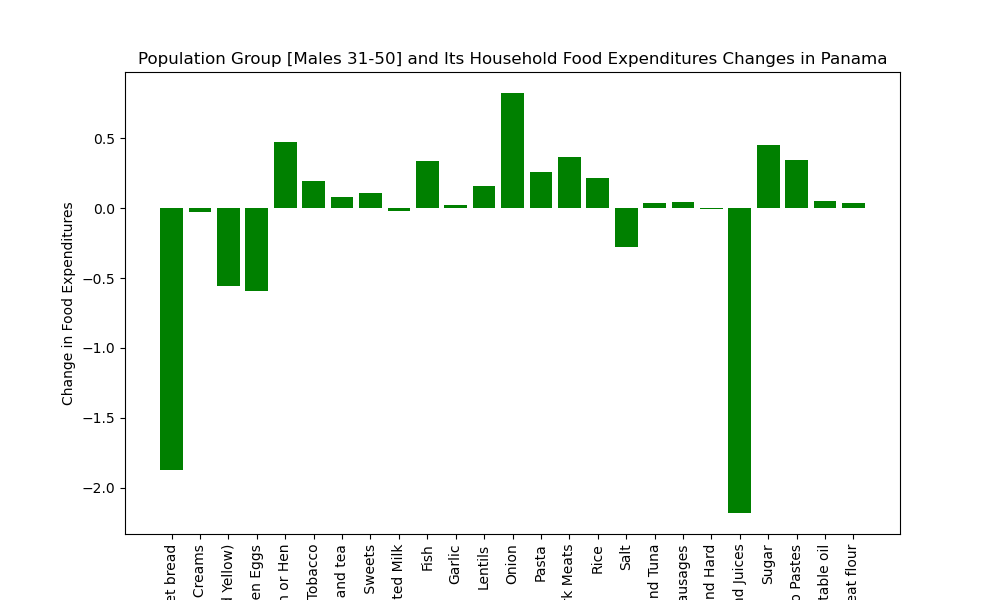

In [ ]:
# Create a bar chart for food elasticities of different population groups
def plot_gamma_table(gamma_table, population_group):
    """
    Ths function is designed to help create a bar chart displaying food expenditure changes with variations of household composition.

    Parameters:
    - gamma_table (DataFrame): The gamma table above.
    - population_group (string): Any population group (string) from the header of gamma table

    Returns:
    - A bar chart described above.
    
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(gamma_table.index, gamma_table[population_group], color='green')
    ax.set_title(f'Population Group [{population_group}] and Its Household Food Expenditures Changes in Panama')
    ax.set_xlabel('Foods')
    ax.set_ylabel('Change in Food Expenditures')
    plt.xticks(rotation=90)
    plt.show()

print('Please choose from the following:\n"women", "boys", "men", "girls", "Males 00-03", "Females 00-03", "Males 04-08", "Females 04-08", "Males 09-13", "Females 09-13", "Males 14-18", "Females 14-18",\n "Males 19-30", "Females 19-30", "Males 31-50", "Females 31-50", "Males 51-99", "Females 51-99"')
print("\n")  
population_input = input('Please input the population group you would like to visualize (No quotation mark required): ')
plot_gamma_table(gamma_df, population_input)

### *__<span style = "color:skyblue">Interpretation: Taking males aged 31 to 50 as an example, it's apparent from the graph that there are two extended bars positioned negatively. This suggests that for every additional male aged 31 to 50 in the household, the consumption of sodas, soft drinks, and juices, as well as bread of salt and sweet bread (related to food expenses), will significantly decrease by approximately 1.8 units. Conversely, the consumption of onions will increase by around 0.8 units.__*

Please choose from the following:
"women", "boys", "men", "girls", "Males 00-03", "Females 00-03", "Males 04-08", "Females 04-08", "Males 09-13", "Females 09-13", "Males 14-18", "Females 14-18",
 "Males 19-30", "Females 19-30", "Males 31-50", "Females 31-50", "Males 51-99", "Females 51-99"




Please input the first population group you would like to visualize (No quotation mark required):  Males 31-50


Please input a population group you would like to visualize and compare with the first chosen one (No quotation mark required):  Females 31-50


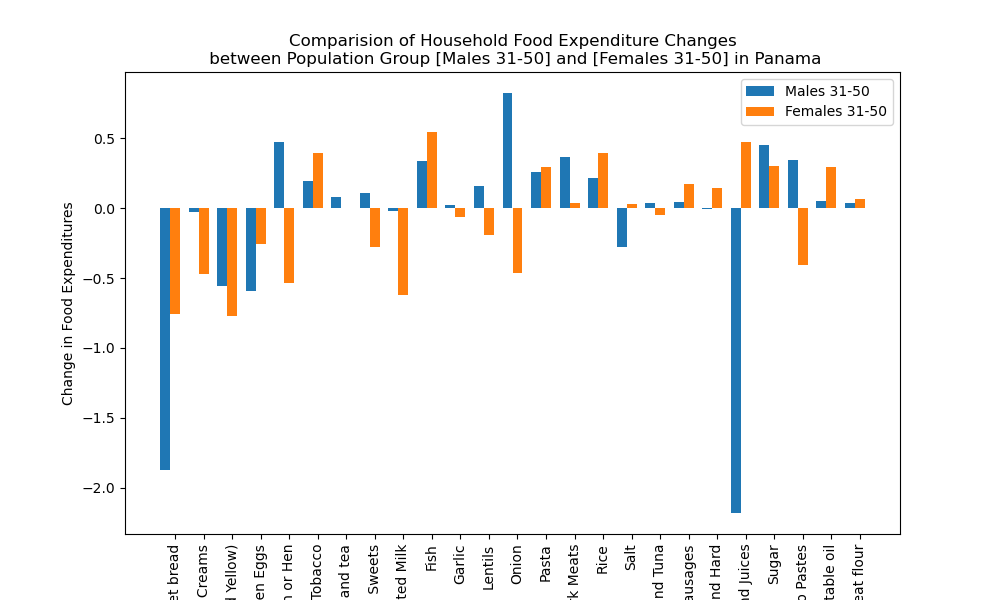

In [ ]:
def plot_two_gamma_table(gamma_table, population_groups):
    """
    Ths function is designed to help combine two bar charts displaying food expenditure changes with variations of household composition, and do the comparision.
    
    Parameters:
    - gamma_table (DataFrame): The gamma table above.
    - population_group (list): It should be a list of two population group (string) from the header of gamma table

    Returns:
    - A bar chart described above.
    
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    width = 0.7 
    num_groups = len(population_groups)
    bar_width = width / num_groups  # Adjusting the bar width for multiple groups

    for i, population_group in enumerate(population_groups):
        x = range(len(gamma_table.index))
        ax.bar([pos + i * bar_width for pos in x], gamma_table[population_group], bar_width, label=population_group)

    ax.set_title(f'Comparision of Household Food Expenditure Changes\n between Population Group [{population_groups[0]}] and [{population_groups[1]}] in Panama')
    ax.set_xlabel('Foods')
    ax.set_ylabel('Change in Food Expenditures')
    ax.set_xticks([pos + width / 2 for pos in x])
    ax.set_xticklabels(gamma_table.index, rotation=90)
    ax.legend()
    plt.show()

print('Please choose from the following:\n"women", "boys", "men", "girls", "Males 00-03", "Females 00-03", "Males 04-08", "Females 04-08", "Males 09-13", "Females 09-13", "Males 14-18", "Females 14-18",\n "Males 19-30", "Females 19-30", "Males 31-50", "Females 31-50", "Males 51-99", "Females 51-99"')
print("\n")  
population_input_list_1 = input('Please input the first population group you would like to visualize (No quotation mark required): ')
print("\n")  
population_input_list_2 = input('Please input a population group you would like to visualize and compare with the first chosen one (No quotation mark required): ')

population_groups = [population_input_list_1, population_input_list_2]  # List of population groups
plot_two_gamma_table(gamma_df, population_groups)

### *__<span style = "color:skyblue">Interpretation: Taking males and females aged 31 to 50 as an example, in addition to the evident comparison of bar lengths, there are also noteworthy observations. For instance, as depicted in the figure, there's an intriguing contrast in onion consumption between men and women in this age group within the household. Men aged 31 to 50 tend to increase onion consumption, whereas women in the same age group tend to decrease onion consumption.__*

<br>

* ### *Analyze the impact of province or region on food expenditure:*

<br>

$$
      y^j_{i} = \gamma_j'd_i+ \zeta^j_i.
$$
<br>

> $y_{i}^j$ : *__Logarithmic expenditures on food $j$ by household $i$ at a particular time.__*
>
> $\gamma_j'd_i$ : *__Variable $d_i$ represents household characteristics. The coefficient $\gamma_j'$ signifies how food expenditure changes in response to variations in household composition.__*
> >* __<span style = "color:red">We employ the "`HH_characteristics_dummy`" dataset, which incorporates a binary variable for province within the Household Characteristics.__
> >* __<span style = "color:red">By analyzing the parameter $\gamma$, which encompasses the coefficients of the binary variables for province, we can assess the impact of provincial differences on food expenditure.__
> >* __<span style = "color:red">Notes: Again, our reference region group is Panamá city which is the capital of the country.__
>
> $\zeta^j_i$ : *__The error term represents all sources of variation in the dependent variable ($y_{i}^j$) that are not explained by the independent variables included in regression function.__*


<br>

In [ ]:
HH_characteristics_dummy.head()

,,,women,boys,men,girls,Males 00-03,Females 00-03,Males 04-08,Females 04-08,Males 09-13,Females 09-13,...,Coclé,Colón,Comarca Emberá,Comarca Kuna Yala,Comarca Ngobe Bugle,Comarca de San Blas,Darién,Herrera,Los Santos,Veraguas
i,t,m,,,,,,,,,,,,,,,,,,,,,
1997125,1997,Herrera,1,1,1,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1997160,1997,Herrera,2,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1997170,1997,Bocas Del Toro,1,3,1,4,1,2,1,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1997177,1997,Bocas Del Toro,4,9,1,5,2,1,4,1,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1997178,1997,Bocas Del Toro,2,1,2,2,0,0,0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# To enhance the model's accuracy, we may encounter foods with very low consumption rates, making it challenging to reliably estimate their demand. 
# We can adjust the min_obs parameter; increasing its value will result in dropping more foods from the analysis.
# Expenditures = drop_columns_wo_covariance(Expenditures,min_obs=30)

# Take the logarithm to Expenditures. 
Expenditures_log = np.log(Expenditures)
use = Expenditures_log.index.intersection(HH_characteristics_dummy.index)
Expenditures_log = Expenditures_log.loc[use,:]
HH_characteristics_dummy = HH_characteristics_dummy.loc[use,:]

Expenditures_log = Expenditures_log.stack()
HH_characteristics_dummy = HH_characteristics_dummy.stack().rename_axis(['i','t','m','k'])

# Check that indices are in right places.
assert Expenditures_log.index.names == ['i','t','m','j']
assert HH_characteristics_dummy.index.names == ['i','t','m','k']

# Remove Ruplicated Indexes.
Expenditures_log = Expenditures_log.groupby(level = Expenditures_log.index.names).mean()

### Regession SetUp
result_region = Regression(y = Expenditures_log,d = HH_characteristics_dummy)

In [ ]:
result_region.predicted_expenditures()

i         t     m                    j                            
20081     2008  Bocas Del Toro       Bread of salt and sweet bread     3.398939
                                     Cereals and Creams                2.292753
                                     Cheese (White and Yellow)         2.153911
                                     Chicken Eggs                      2.481733
                                     Chicken or Hen                   10.531157
                                                                        ...    
20087040  2008  Comarca Ngobe Bugle  Sodas, Soft Drinks and Juices     3.119313
                                     Sugar                             5.569051
                                     Tomato Pastes                     1.181704
                                     Vegetable oil                     2.672165
                                     Wheat flour                       3.470371
Length: 402075, dtype: float64

In [ ]:
gamma_df_region = result_region.gamma
gamma_df_region.head()

k,women,boys,men,girls,Males 00-03,Females 00-03,Males 04-08,Females 04-08,Males 09-13,Females 09-13,...,Colón,Comarca Emberá,Comarca Kuna Yala,Comarca Ngobe Bugle,Comarca de San Blas,Darién,Herrera,Los Santos,Veraguas,Constant
j,,,,,,,,,,,,,,,,,,,,,
Bread of salt and sweet bread,0.769214,1.769637,1.693257,0.711399,-1.896084,-0.851049,-1.806685,-0.773181,-1.782561,-0.770166,...,-0.119219,-0.651744,0.193368,-1.214684,-0.005142,-0.478825,-0.128844,-0.127576,-0.554937,0.937538
Cereals and Creams,0.433823,-0.088369,-0.077752,0.432202,0.006038,-0.550687,0.034068,-0.500533,-0.021909,-0.577495,...,0.100054,-1.297707,-0.141337,-0.545774,-1.022540,-0.557883,-0.385782,-0.397236,-0.418562,0.580965
Cheese (White and Yellow),0.756470,0.457063,0.398515,0.733691,-0.589952,-0.869085,-0.508067,-0.816862,-0.479294,-0.829647,...,-0.008411,-1.620494,0.217682,-0.737267,-0.711392,-0.362168,-0.189193,-0.209755,-0.459744,0.744205
Chicken Eggs,0.247553,0.587901,0.570765,0.217241,-0.638887,-0.305556,-0.609825,-0.258805,-0.616282,-0.232971,...,-0.026262,-0.237257,0.210417,-0.332429,-0.479562,0.037830,-0.195241,-0.240576,-0.336128,0.339284
Chicken or Hen,0.707355,-0.514920,-0.541201,0.706517,0.400924,-0.829273,0.420434,-0.774229,0.451442,-0.765459,...,-0.134635,-0.038490,-0.344024,-0.468826,-0.606722,-0.080629,-0.186041,-0.216348,-0.329565,1.902183


Please choose from the following:
'Bocas del Toro', 'Chíriqui', 'Coclé', 'Colón','Comarca Emberá', 'Comarca Kuna Yala', 'Comarca Ngobe Bugle','Comarca de San Blas', 'Darién', 'Herrera', 'Los Santos','Veraguas', 'Constant'




Please input the population group you would like to visualize (No quotation mark required):  Colón


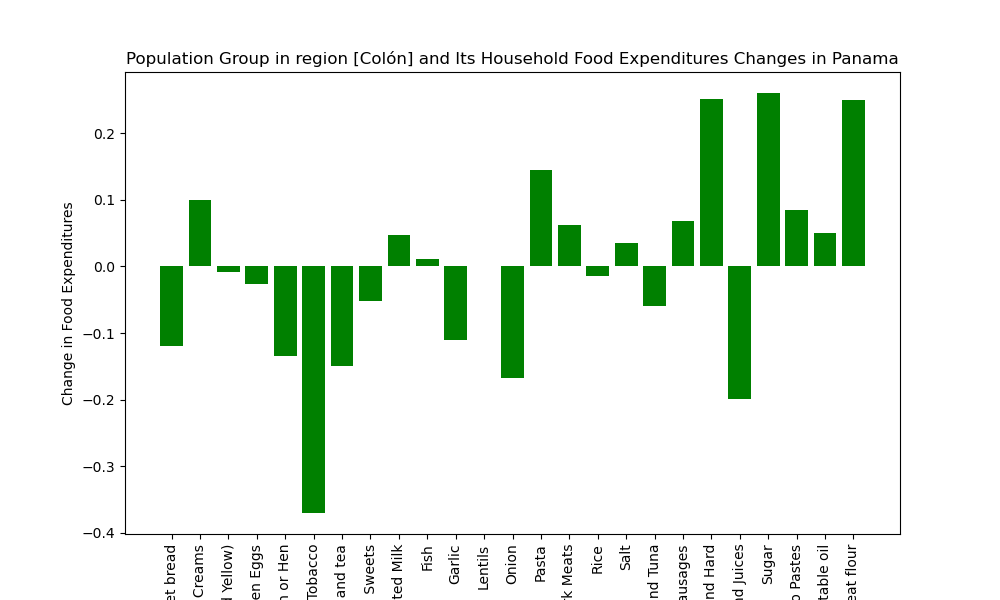

In [ ]:
# Create a bar chart for food elasticities of different region population groups
def plot_gamma_table(gamma_table, population_group):
    """
    Ths function is designed to help create a bar chart displaying food expenditure changes with variations of household composition.

    Parameters:
    - gamma_table (DataFrame): The gamma table above.
    - population_group (string): Any population group (string) from the header of gamma table

    Returns:
    - A bar chart described above.
    
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(gamma_table.index, gamma_table[population_group], color='green')
    ax.set_title(f'Population Group in region [{population_group}] and Its Household Food Expenditures Changes in Panama')
    ax.set_xlabel('Foods')
    ax.set_ylabel('Change in Food Expenditures')
    plt.xticks(rotation=90)
    plt.show()
print("Please choose from the following:\n'Bocas del Toro', 'Chíriqui', 'Coclé', 'Colón','Comarca Emberá', 'Comarca Kuna Yala', 'Comarca Ngobe Bugle','Comarca de San Blas', 'Darién', 'Herrera', 'Los Santos','Veraguas', 'Constant'")
print("\n")  
population_input = input('Please input the population group you would like to visualize (No quotation mark required): ')
plot_gamma_table(gamma_df_region, population_input)

### *__<span style = "color:skyblue">Interpretation: The omitted region category our group chose is "Panamá" region since it is the capital . It is essentially becomes the reference or baseline group. Coefficients of households living in Colón to food exependiture shown on the plot: The coefficients of the included dummy variables represent the difference in the food expenditure for observations in that region compared to the omitted "Panamá" region, holding all other variables constant.__*

<br>

## __[B] Nutritional Content of Different Foods__

In [ ]:
### nutritions for each food
fct.head()

n,Water,Energy,Protein,Total Fat,Carbohydrates,Diet Fiber. total,Ash,Calcium,Match,Iron,...,Cholesterol,Potassium,Sodium,Zinc,Magnesium,Vit. B6,Vit. B12,Ac. Folic,Folate Equiv. F.D.,Edible Fraction
j,,,,,,,,,,,,,,,,,,,,,
Vegetable oil,0.00,884,0.00,100.00,0.00,0.0,0.00,0,0,0.00,...,0,0,0,0.00,0,0.00,0.0,0,0,1.00
Avocados,73.23,160,2.00,14.66,8.53,6.7,1.58,12,52,0.55,...,0,485,7,0.64,29,0.26,0.0,0,81,0.74
Sweet green chili,93.89,20,0.86,0.17,3.64,1.7,0.43,10,20,0.34,...,0,175,3,0.13,10,0.22,0.0,0,11,0.82
Garlic,63.80,134,5.30,0.20,29.30,0.0,1.40,38,134,1.40,...,0,529,19,1.00,0,0.00,0.0,3,0,0.94
Baby formula,3.00,510,12.50,27.00,54.30,0.0,3.20,530,420,9.00,...,0,600,180,6.00,55,0.30,1.5,80,136,1.00


In [ ]:
### recommanded daily allowances
new_column_names = [
"Females 00-03", "Males 00-03", "Females 04-08", "Males 04-08", "Females 09-13", "Males 09-13", "Females 14-18", "Males 14-18",  "Females 19-30", "Males 19-30", "Females 31-50", "Males 31-50",  "Females 51-99", "Males 51-99"]
column_name_mapping = {old: new for old, new in zip(rdi.columns, new_column_names)}
rdi.rename(columns=column_name_mapping, inplace=True)

rdi.head()

k,F 00-03,M 00-03,F 04-08,M 04-08,F 09-13,M 09-13,F 14-18,M 14-18,F 19-30,M 19-30,F 31-50,M 31-50,F 51+,M 51+
n,,,,,,,,,,,,,,
Energy,1000.0,1000.0,1200.0,1400.0,1600.0,1800.0,1800.0,2200.0,2000.0,2400.0,1800.0,2200.0,1600.0,2000.0
Protein,13.0,13.0,19.0,19.0,34.0,34.0,46.0,52.0,46.0,56.0,46.0,56.0,46.0,56.0
Fiber,14.0,14.0,16.8,19.6,22.4,25.2,25.2,30.8,28.0,33.6,25.2,30.8,22.4,28.0
Folate,150.0,150.0,200.0,200.0,300.0,300.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0
Calcium,700.0,700.0,1000.0,1000.0,1300.0,1300.0,1300.0,1300.0,1000.0,1000.0,1000.0,1000.0,1200.0,1000.0


<br>

## __[B] Nutritional Adequacy of Diet__

In [ ]:

xhat = result.predicted_expenditures()
prices_kg = read_sheets(key='https://docs.google.com/spreadsheets/d/1P7OQG9cmBSS4dY6ZPI1HOPHW9shCTSkguDVnUCuh3Is/edit#gid=199254621', sheet="Food Prices in Kilograms 1")
if 'm' not in prices_kg.columns:  
    prices_kg['m'] = 1

prices_kg = prices_kg.set_index(['t','m'])
prices_kg.columns.name = 'j'

prices_kg = prices_kg.apply(lambda x: pd.to_numeric(x,errors='coerce'))
prices_kg = prices_kg.replace(0,np.nan)

qhat = (xhat.unstack('j')/prices_kg).dropna(how='all')
qhat = qhat.loc[:,qhat.count()>0]

use = fct.index.intersection(qhat.columns)

nutrients = qhat[use]@fct.loc[use,:]

nutrients.mean()

HH_characteristics = get_clean_sheet(InputFiles['HH Characteristics'][0],
                    sheet=InputFiles['HH Characteristics'][1])

if 'm' not in HH_characteristics.columns:
    HH_characteristics['m'] = 1

HH_characteristics = HH_characteristics.set_index(['i','t','m'])
HH_characteristics.columns.name = 'k' 

HH_characteristics = HH_characteristics.apply(lambda x: pd.to_numeric(x,errors='coerce'))

HH_characteristics = HH_characteristics[rdi.columns.tolist()]

hh_rdi = HH_characteristics@rdi.T

#check recommended weekly intake?
hh_rwi = hh_rdi*7
use_nutrients = nutrients.columns.intersection(hh_rwi.columns)
nutrient_ratio = (nutrients[use_nutrients]/hh_rwi[use_nutrients]).dropna()

nutrient_ratio

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

nutrient_ratio['Protein'].hist(bins=30)


<br>

## __[C] Counterfactual Experiments__

* ### *If total food expenditures doubled and holding prices fixed:*

In [ ]:
Expenditures_double = Expenditures.apply(lambda x: x * 2)
Expenditures_double.head()

,,j,Vegetable oil,Avocados,There Green,Garlic,Infant Food,Celery,Rice,Chickpeas,Sugar,Coffee and tea,...,"Sodas, Soft Drinks and Juices",Canned Soup,third other,Tomato,Beef Viscera,Chicken or Hen Viscera,Yucca,Carrot,Pumpkin / Chayote,Yam
i,t,m,,,,,,,,,,,,,,,,,,,,,
19971000,1997,Chíriqui,12.0,NaN,1.0,NaN,5.4,0.6,14.5,NaN,3.2,NaN,...,16.0,1.4,NaN,NaN,NaN,NaN,NaN,1.6,NaN,0.8
19971001,1997,Chíriqui,NaN,NaN,NaN,NaN,NaN,NaN,9.6,NaN,NaN,2.8,...,3.0,NaN,NaN,0.6,NaN,NaN,NaN,NaN,NaN,NaN
19971002,1997,Chíriqui,7.0,NaN,NaN,NaN,NaN,NaN,12.0,NaN,4.0,7.2,...,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
19971003,1997,Chíriqui,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19971005,1997,Chíriqui,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,3.0,...,NaN,1.4,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN


In [ ]:
# Nutrition Analysis



<br>

* ### *If total food prices doubled and holding others fixed:*

In [ ]:
prices_double = prices.apply(lambda x: x * 2)
prices_double.head()

j                   Vegetable oil                                          \
u                      1/2 gallon None bottle   can gallon gram large bay   
t    m                                                                      
1997 Bocas Del Toro          6.45  NaN   2.40  5.95   13.4  NaN      3.00   
     Chíriqui                6.50  0.2   2.70   NaN   11.9  NaN      2.70   
     Coclé                   5.98  0.2   2.60   NaN   11.8  NaN      2.75   
     Colón                   6.50  0.2   2.68   NaN   11.5  NaN       NaN   
     Darién                  6.40  0.5   2.80   NaN    9.7  NaN      3.05   

j                                                ... Pumpkin / Chayote  \
u                   liter medium bar milliliter  ...              unit   
t    m                                           ...                     
1997 Bocas Del Toro   NaN       2.10        NaN  ...               0.2   
     Chíriqui         NaN       2.65        NaN  ...               0.2   
     Coclé            NaN       2.55        NaN  ...               0.3   
     Colón            NaN       1.70        NaN  ...               0.5   
     Darién           NaN       2.80        NaN  ...               NaN   

j                                     Yam                                \
u                       value bag or sack gram ounce package pound unit   
t    m                                                                    
1997 Bocas Del Toro       NaN         7.2  NaN   NaN     NaN   0.8  NaN   
     Chíriqui        0.168831         NaN  NaN   NaN     NaN   0.8  0.3   
     Coclé           0.402597         NaN  NaN   NaN     NaN   1.0  1.0   
     Colón           0.090909         NaN  NaN   NaN     NaN   0.8  1.2   
     Darién               NaN         NaN  NaN   NaN     NaN   0.3  NaN   

j                              m  
u                       value     
t    m                            
1997 Bocas Del Toro       NaN  2  
     Chíriqui        0.077922  2  
     Coclé                NaN  2  
     Colón           0.129870  2  
     Darién               NaN  2  

[5 rows x 691 columns]

In [ ]:
# Nutrition Analysis

